# Using K-Means ML Algorithm to Segment the Customers

In this project, we will use machine learning algorithm K-Means to segment the customers list. We'll be using `scikit-learn` library to create clusters and `Matplotlib` and `Seaborn` libraries to visualize the clusters. 

# Importing Libraries and Dataset 

We'll kick-start the project by importing required libraries. 

In [1]:
# Filter FutureWarning and UserWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# KMeans algorithm from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# To deal with dataframe and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Then we will read the data and modify it by `CustomerID` column as it can't be used for clustering. We'll use all other features for clustering. So we'll turn categorical feature `Gender` into numerical values by assigning `1` to `Male` and `0` to `Female`.

In [2]:
customers = pd.read_csv("C:/Users/Linus/Documents/Sheets/Mall_Customers.csv")
customers_modif = customers.copy()
customers_modif.drop('CustomerID', axis=1, inplace=True)
customers_modif['Gender'] = customers_modif['Gender'].map({'Male': 1, 'Female': 0})

# Creating Functions

The core of the K-means algorithm is the computation of distances between points, either for assigning clusters, calculating centroids, or calculating the inertia generated by the split. Therefore, if the variables in the dataset are of incomparable magnitudes, this could be an issue. Therefore, we need to bring all the features to a similar scale. The standardization is done by calculating the z-score for each observation in a column. 

Then to find ideal number of clusters based on inertia, we need to plot Elbow Curve. We'll iterate over number of clusters and find inertia. Then use line plot to find relation between Cluster and Interia which is called as Elbow Curve. 

For both these, we will crate functions that will take DataFrame as input and return required outputs.

In [3]:
# Scaler function takes DataFrame, scale it using Scikit Standard Scaler and returns scaled DataFrame
def scaler(df):
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    return df_scaled

# This function takes DataFrame, calculates inertia for different number of clusters, & plots Elbow curve
def plot_elbow_curve(df, max_clusters=10):
    inertias = []
    
    # Model variable will store created clusters and inertia is appended to master list of inertias.
    for k in range(1, max_clusters+1):
        model = KMeans(n_clusters=k, random_state=42)
        cluster = model.fit_predict(df)
        inertias.append(model.inertia_)
    
    # Elbow Curve is created 
    plt.figure(figsize=(12, 8))
    plt.plot(range(1, max_clusters+1), inertias, marker='o')
    plt.xticks(ticks=range(1, max_clusters+1), labels=range(1, max_clusters+1))
    plt.title('Inertia vs Number of Clusters')

    plt.tight_layout()
    plt.show()
    
    return inertias

# Elbow Curve

We will use previously created functions to scale the features from DataFrame and plot elbow curve. 

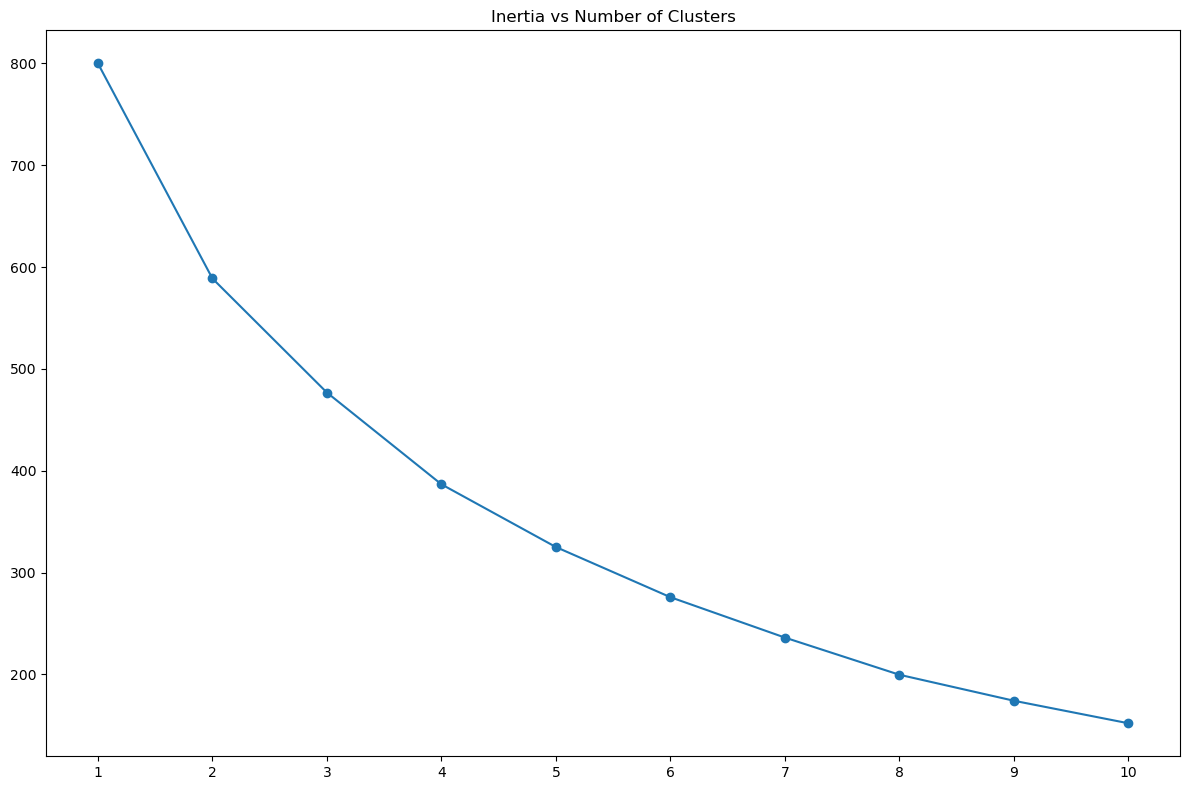

[800.0,
 588.8026767824936,
 476.7875544135159,
 386.7147857740688,
 325.10998348953444,
 275.85884311304983,
 236.2049470708688,
 199.7166255966767,
 174.1930957085769,
 152.0867629871069]

In [4]:
scaled_customers = scaler(customers_modif)
plot_elbow_curve(scaled_customers)

# Choosing the Cluster

Since there is no sharp elbow in the curve, deciding the best number of clusters from the Elbow Curve isn't very helpful.

Here are some possible alternatives:
* Gathering more data.
* Looking for new features.
* Looking for business rules or insights that might lead to a decision for one cluster over another.
* Trying different numbers of clusters to see how the split goes in each of them.

Since we don't have any of them, we'll choose one good cluster. The best possible candidates here are five, six, and seven clusters. We'll choose six and move on to the split and then interpret the results.

In [5]:
model = KMeans(n_clusters=6, random_state=42)
clusters = model.fit_predict(scaled_customers)

customers['Cluster'] = clusters+1
print(customers['Cluster'].value_counts())

4    41
5    38
2    37
3    35
1    26
6    23
Name: Cluster, dtype: int64


# Interpreting Results — Numerical Variables

Now, it's time to interpret the results and summarize the characteristics of each cluster and differentiate them from each other based on the variables used for the segmentation.

First, we'll analyze the numerical variables and see how they behave in each cluster. 

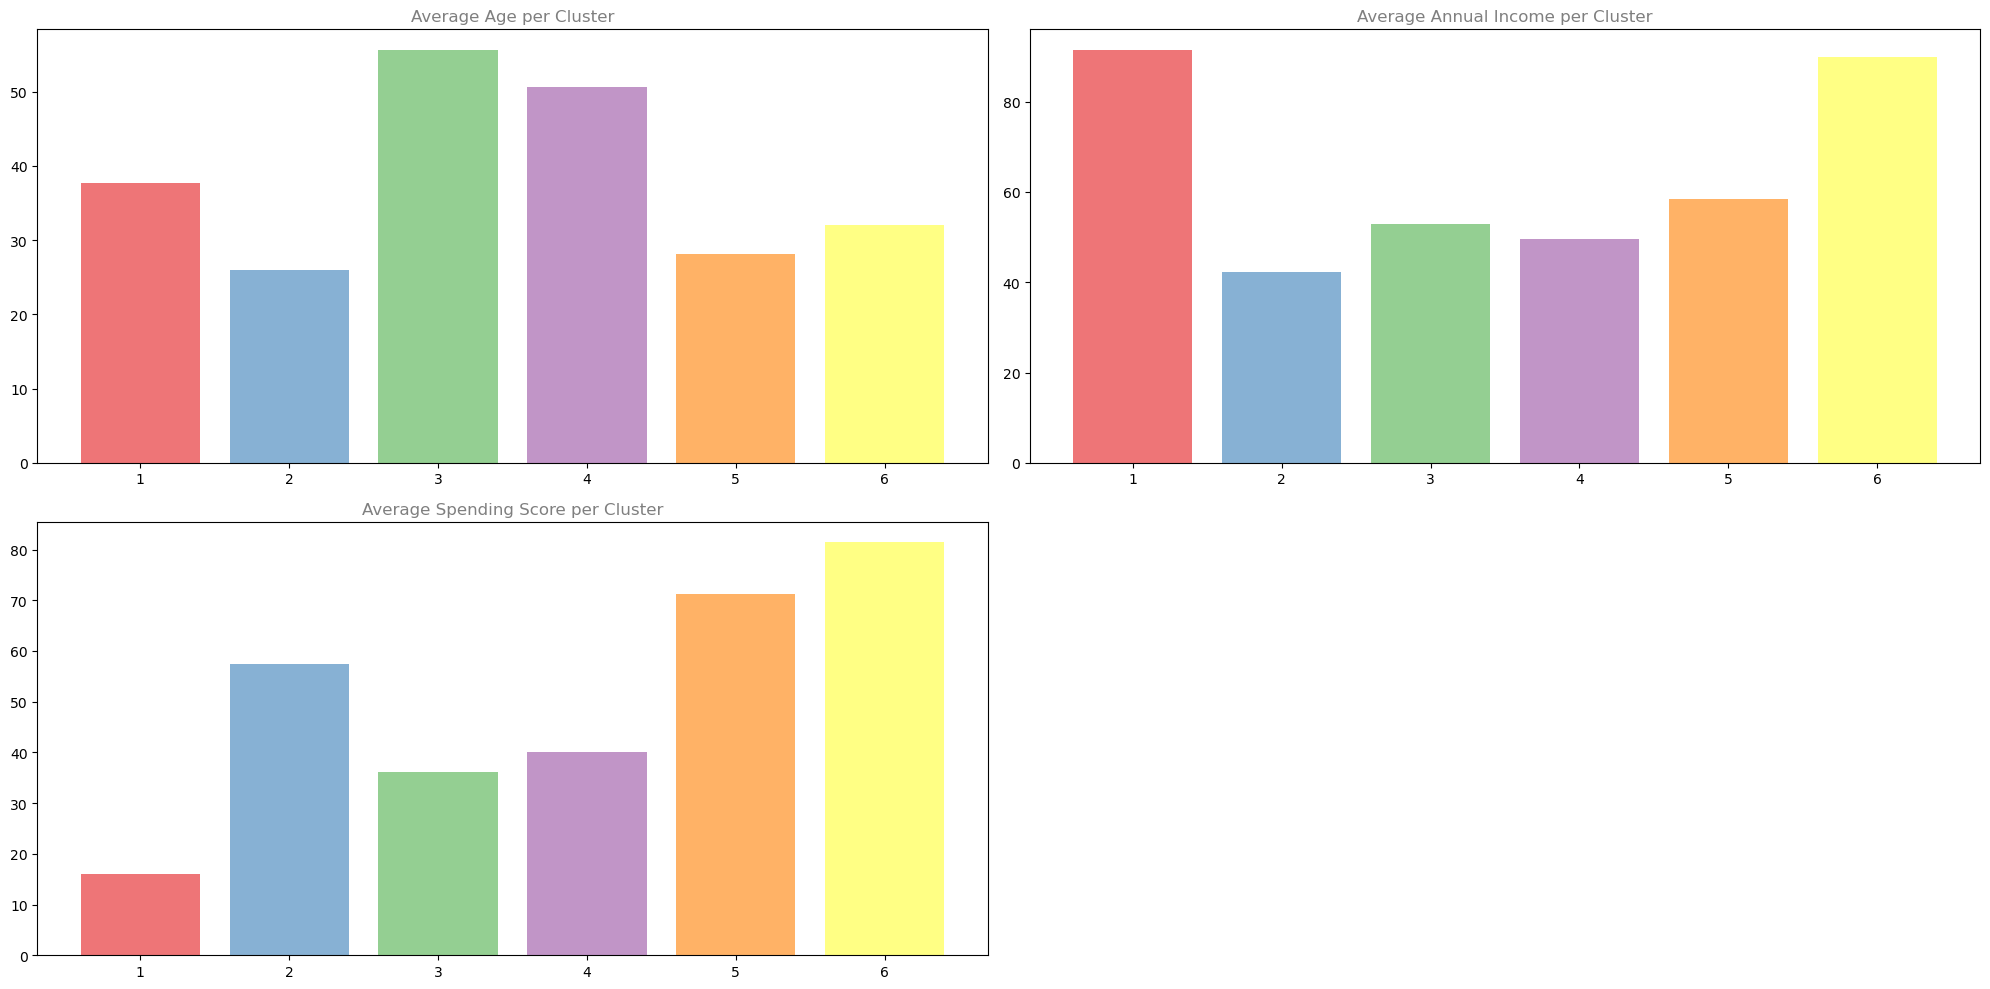

In [6]:
numeric_columns = ['Age', 'Annual Income', 'Spending Score']

fig = plt.figure(figsize=(20, 10))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('Cluster')[column].mean()
    ax = fig.add_subplot(2, 2, i+1)
    
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'), alpha=0.6)
    ax.set_title(f'Average {column.title()} per Cluster', alpha=0.5)
    ax.xaxis.grid(False)
    
plt.tight_layout()
plt.show()

The conclusions from the previous screen enable us to understand each cluster and then use them to make business decisions. For instance, customers in cluster 6 have a very high income and the highest spending score. This means that they're best to target for selling luxury or high-ticket items.

With this kind of information, the marketing team could develop a campaign focused on this cluster specifically and try to incite those customers to spend more money.

However, there's more for us to investigate. Scatter plots are a great tool for understanding variable distribution between clusters. To plot these charts, `seaborn.scatterplot` is a great tool because it easily allows us to plot the data grouped by a variable through the parameter hue.


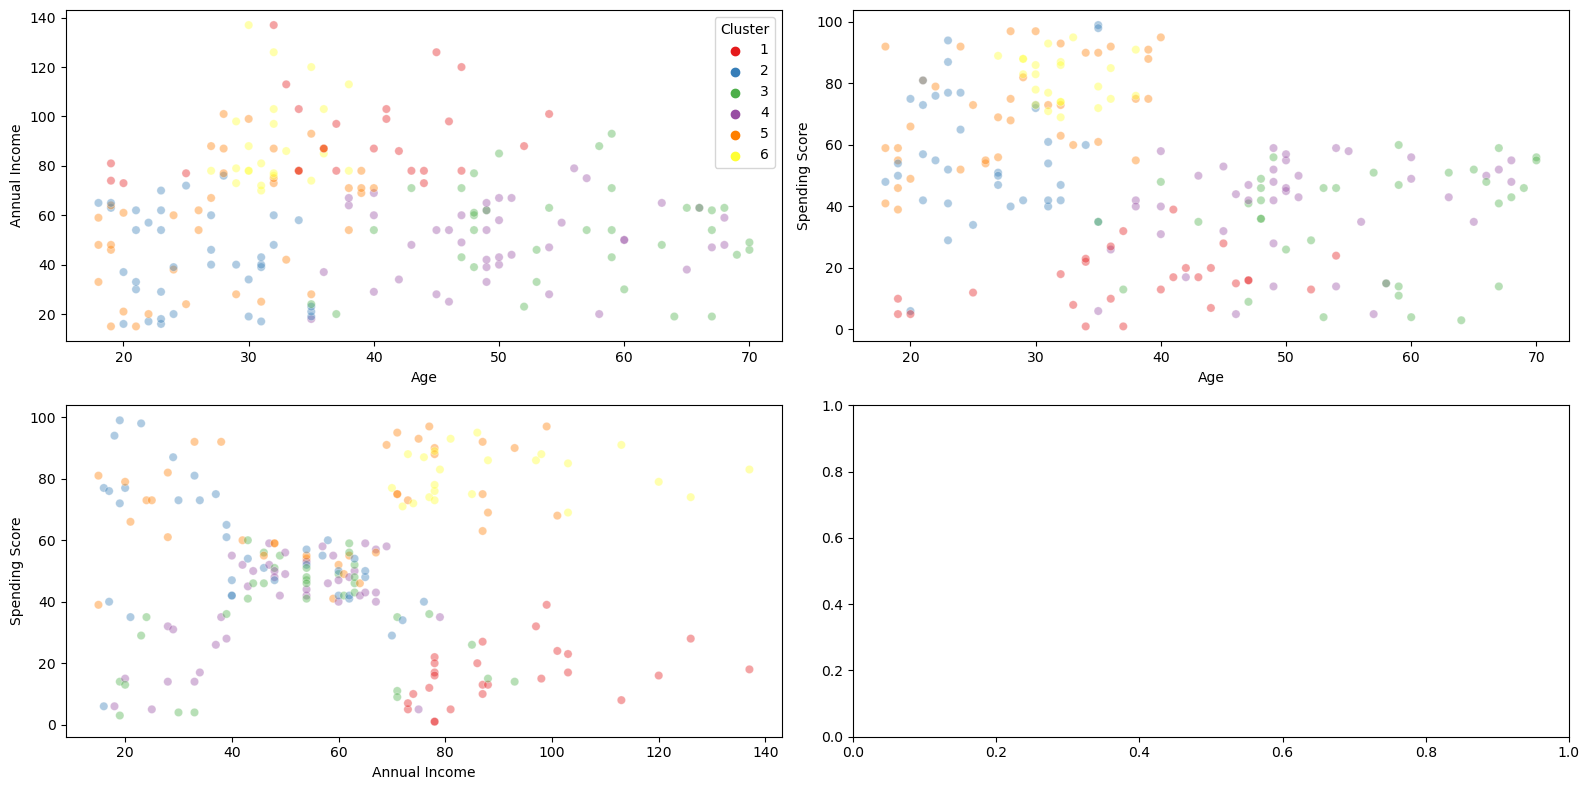

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
sns.scatterplot(x='Age', y='Annual Income', hue='Cluster', data=customers, 
                palette='Set1', alpha=0.4, ax=axs[0][0])

sns.scatterplot(x='Age', y='Spending Score', hue='Cluster', data=customers, 
                palette='Set1', alpha=0.4, ax=axs[0][1], legend=False)

sns.scatterplot(x='Annual Income', y='Spending Score', hue='Cluster', data=customers, 
                palette='Set1', alpha=0.4, ax=axs[1][0], legend=False)

plt.tight_layout()
plt.show()

Above scatter plots help us understand numerical features even more. We can confirm from 3rd plot that cluster 6 has customers who are high earning and have high spending score.  

While the bar charts show each variable at a time per cluster, the scatter plots enable us to easily understand how two variables relate to each other.

#  Interpreting Results — Categorical Variables

So, now we need to understand how the categorical column Gender impacts the cluster split. Is the cluster with customers from only one gender? Are any clusters equally divided between men and women?

Unlike the numerical columns, a scatter plot wouldn't show much value when analyzing a categorical column, even if you transformed the text value to numeric again. Therefore, our goal is to visualize the percentage of each category (male and female) in each one of our six clusters.

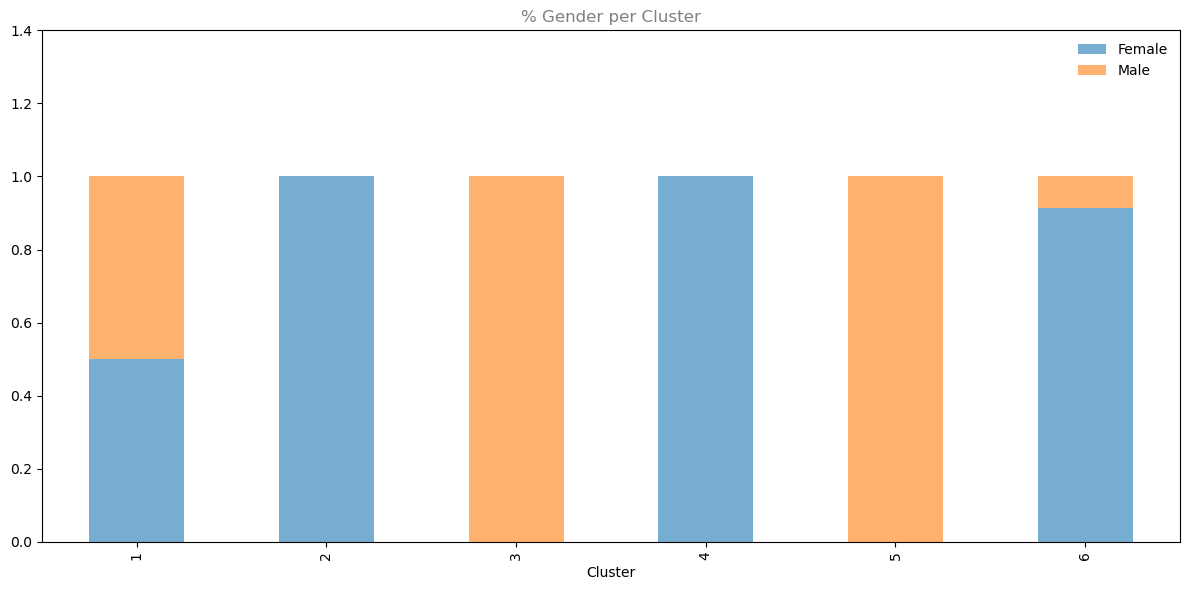

In [8]:
plot_df = pd.crosstab(
  index=customers['Cluster'], columns=customers['Gender'],
  values=customers['Gender'], aggfunc='size', normalize='index'
)


fig, ax = plt.subplots(figsize=(12,6))
plot_df.plot.bar(stacked=True, ax=ax, alpha=0.6)
ax.set_title(f'% Gender per Cluster', alpha=0.5)

ax.set_ylim(0, 1.4)
ax.legend(frameon=False)
ax.xaxis.grid(False)

plt.tight_layout()
plt.show()

We can see that 4 of 6 clusters only have 1 gender, while other 2 have both genders on varying proportions. Cluster 6 is dominated by Female customers! 

# Export the Results

Now finaly we will export the results to CSV file which will be having number of cluster for every customer.

In [9]:
customers.to_csv("clustered_mall_customers.csv")